In [ ]:
%load_ext autoreload
%autoreload 2

In [43]:
%matplotlib qt

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from renewableopt.data import load_by_day
from renewableopt.optimal_design import visualize
from renewableopt.peak_id import (
    reshape_by_day, timedelta, topo_argmax, gamma_matrix,
    assert_partition, manual_clustering,
    identify_worst_days, worst_case_by_group, assert_int
)
from itertools import groupby
from sklearn.cluster import KMeans


In [55]:
sources = ['solar', 'wind', 'geothermal']
time, load, gen_pu = load_by_day(0, 366, sources=sources)
time = time / 60  # Convert to hours!
dt = timedelta(time)

In [67]:
peak_data = identify_worst_days(time, load, gen_pu, sources=sources, method="kmeans_cluster")

In [68]:
visualize.plot_wind_solar_cluster(peak_data)

In [65]:
visualize.plot_cluster_1d(peak_data)

In [6]:
timesteps_per_day = assert_int(24 / dt)
days = assert_int(time.shape[0] / timesteps_per_day)

In [7]:
time_per_day, load_per_day, gen_pu_per_day = reshape_by_day(
    time, load, gen_pu
)

In [8]:
gamma = gamma_matrix(timesteps_per_day, dt)
energy_gen_per_day = np.einsum('ijk,ja->iak', gen_pu_per_day, gamma.T)

In [9]:
assert np.all(energy_gen_per_day[:, :, 0] == gen_pu_per_day[:, :, 0] @ gamma.T)

In [10]:
topo_argmax(energy_gen_per_day).shape

(86,)

In [40]:
# We've got an issue with the solar data for the last days of the year!!
plt.plot(energy_gen_per_day[365])

In [12]:
# Order by peak load and minimum daily solar generation.
peak_loads = np.max(load_per_day, axis=-1)
daily_gen = np.min(energy_gen_per_day, axis=1)
problem_days = topo_argmax(np.c_[
    peak_loads, daily_gen[:, 0]
])

In [13]:
problem_days = topo_argmax(np.c_[
    peak_loads, daily_gen
])

In [41]:
len(problem_days)

38

In [29]:
problem_groups = kmeans_cluster(
    problem_days,
    peak_loads[problem_days],
    -daily_gen[problem_days, :2],
    sources[:2],
    n_clusters=15
)

In [30]:
# names = cluster_names(kmeans, peak_loads[problem_days], -daily_gen[problem_days, :2], sources[:2])

In [31]:
solar_en = -daily_gen[:, 0] / 24 * 100
wind_en = -daily_gen[:, 1] / 24 * 100

In [36]:
list(problem_groups.keys())

['medium_load_medium_solar_low_wind_0',
 'high_load_high_solar_low_wind_0',
 'low_load_low_solar_low_wind_0',
 'high_load_medium_solar_low_wind',
 'low_load_medium_solar_low_wind_0',
 'high_load_high_solar_low_wind_1',
 'low_load_low_solar_medium_wind',
 'low_load_low_solar_low_wind_1',
 'medium_load_low_solar_low_wind',
 'low_load_medium_solar_low_wind_1',
 'low_load_out of bounds_solar_high_wind',
 'medium_load_medium_solar_low_wind_1',
 'high_load_high_solar_low_wind_2',
 'low_load_medium_solar_low_wind_2',
 'high_load_high_solar_low_wind_3']

In [37]:
np.argsort(list(problem_groups.keys()))

array([ 1,  5, 12, 14,  3,  2,  7,  6,  4,  9, 13, 10,  8,  0, 11])

In [38]:
fig, plots = plt.subplots(2, 2)
first_run = True
labels = np.sort(list(problem_groups.keys()))
for x, y, i, j in [
    (peak_loads, solar_en, 0, 0),
    (peak_loads, wind_en, 1, 0),
    (wind_en, solar_en, 0, 1),
]:
    for label in labels:
        days = problem_groups[label]
                              
#         group = kmeans.labels_ == label
        plots[i][j].plot(x[days], y[days], 'x', label=label)
        if first_run:
            plots[1][1].plot([0], [0], 'x', label=label)
    first_run = False
plots[0][0].set_xlabel("Peak Load (MW)")
plots[0][0].set_ylabel("solar_pu")
plots[0][1].set_xlabel("wind_pu")
plots[1][0].set_ylabel("wind_pu")
plots[1][1].legend()
plots[1][1].axis("off")

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

In [21]:
kmeans.labels_

array([3, 3, 0, 3, 0, 0, 0, 3, 3, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 3, 3, 3, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 3, 3, 0, 0,
       0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1,
       4, 4, 4, 4, 4, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1,
       1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 2, 2, 1, 1, 4, 4, 1,
       2, 1, 2, 1, 4, 4, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 4, 1, 1, 2, 2,
       1, 4, 2, 1, 4, 4, 2, 2, 2, 4, 4, 4, 0, 0, 0, 1, 4, 4, 0, 0, 0, 0,
       2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,

In [29]:
problem_days

array([  5,  15,  16,  76, 193, 194, 203, 204, 205, 206, 208, 209, 210,
       211, 224, 225, 227, 228, 236, 240, 247, 251, 252, 253, 259, 264,
       265, 271, 319, 320, 334, 340, 342, 347, 350, 352, 356, 358])

In [15]:
def day_to_date(days):
    jan1 = np.datetime64("2012-01-01 00:00")
    return jan1 + np.array(days * 24).astype('timedelta64[h]')

In [16]:
day_to_date(1)

numpy.datetime64('2012-01-02T00:00')

In [17]:
day_to_date(np.argsort(peak_loads)[-10:])

array(['2012-07-23T00:00', '2012-08-12T00:00', '2012-07-29T00:00',
       '2012-07-20T00:00', '2012-07-24T00:00', '2012-07-25T00:00',
       '2012-07-26T00:00', '2012-08-13T00:00', '2012-07-28T00:00',
       '2012-07-27T00:00'], dtype='datetime64[m]')

In [19]:
print(problem_days)
print(daily_gen[problem_days, 0])

[ 76 193 208 209 224 225 252 334 347 352]
[ -0.05235714  -0.45801541 -10.24662325 -10.22810644  -6.49617647
  -7.31194678  -2.72968908  -0.28557703  -0.14651401  -0.215007  ]


In [20]:
problem_days.shape

(10,)

In [21]:
problem_groups = manual_clustering(problem_days, peak_loads, daily_gen[:, 0])
assert_partition(problem_groups.values(), set(problem_days))

In [22]:
problem_groups

{'low_load_low_solar': array([ 76, 334, 347, 352]),
 'medium_load_low_solar': array([193]),
 'medium_load_medium_solar': array([252]),
 'high_load_cloudy': array([224, 225]),
 'high_load_sunny': array([208, 209])}

In [37]:
daily_gen[problem_groups['low_load_low_solar']]

array([[ -0.05235714, -12.22097863, -24.        ],
       [ -0.28557703,  -0.33448382, -24.        ],
       [ -0.14651401,  -3.09504749, -24.        ],
       [ -0.215007  ,  -7.90543802, -24.        ]])

In [38]:
problem_groups

{'low_load_low_solar': array([ 76, 334, 347, 352]),
 'medium_load_low_solar': array([193]),
 'medium_load_medium_solar': array([252]),
 'high_load_cloudy': array([224, 225]),
 'high_load_sunny': array([208, 209])}

In [41]:
daily_gen.shape

(366, 3)

In [ ]:
problem_groups

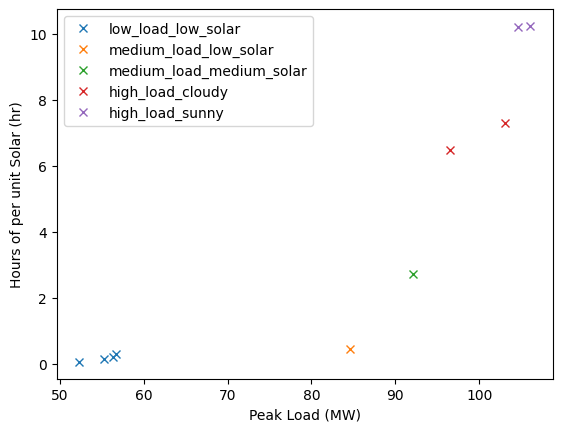

In [27]:
for name, group in problem_groups.items():
    plt.plot(peak_loads[group], -daily_gen[group, 0], 'x', label=name)
plt.xlabel("Peak Load (MW)")
plt.ylabel("Hours of per unit Solar (hr)")
plt.legend()

In [25]:
gen_pu_per_day.shape

(366, 288, 3)

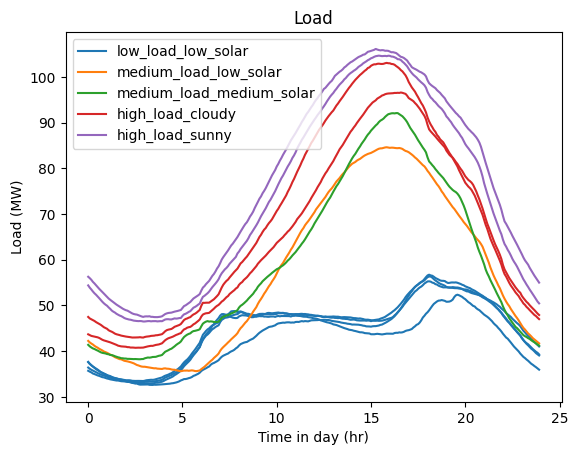

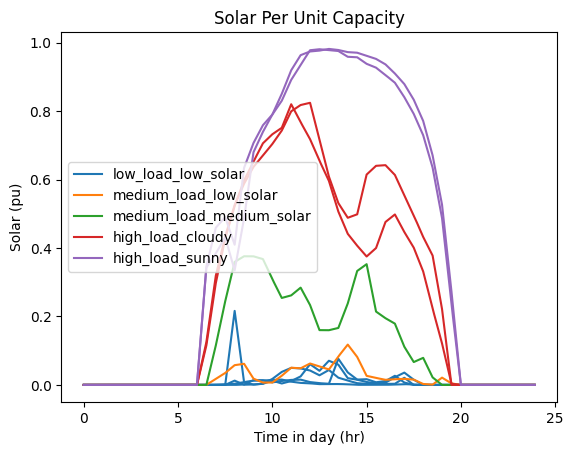

In [26]:
def plot_by_group(y, groups, title=None, ylabel=None):
    handles = []
    labels = []
    for i, (name, group) in enumerate(groups.items()):
        lines = plt.plot(time_per_day[0], y[group].T, label=name, color=f"C{i}")
        if lines:
            handles.append(lines[0])
            labels.append(name)
    if title is not None:
        plt.title(title)
    plt.xlabel('Time in day (hr)')
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.legend(handles, labels)
    
plt.figure()
plot_by_group(load_per_day, problem_groups, title="Load", ylabel="Load (MW)")
plt.figure()
plot_by_group(gen_pu_per_day[..., 0], problem_groups, title="Solar Per Unit Capacity", ylabel="Solar (pu)")
# plt.figure()
# plot_by_group(energy_solar_per_day, problem_groups, title="Load", ylabel="Load (MW)")


In [40]:
# def worst_case_by_group(problem_groups, load_per_day, energy_solar_per_day):
#     worst_load = {
#         name: np.max(load_per_day[group], axis=0)
#         for name, group in problem_groups.items()
#     }
#     worst_solar = {
#         name: np.max(energy_solar_per_day[group], axis=0)
#         for name, group in problem_groups.items()
#     }
#     return worst_load, worst_solar

In [17]:
worst_load, worst_solar_energy = worst_case_by_group(problem_groups, load_per_day, energy_solar_per_day)

In [18]:
worst_solar_energy.keys()

dict_keys(['low_load_low_solar', 'medium_load_low_solar', 'medium_load_medium_solar', 'high_load_cloudy', 'high_load_sunny'])

In [19]:
worst_solar_energy['low_load_low_solar'].shape

(288,)

In [20]:
gamma

array([[-0.08333333,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.08333333, -0.08333333,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.08333333, -0.08333333, -0.08333333, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.08333333, -0.08333333, -0.08333333, ..., -0.08333333,
         0.        ,  0.        ],
       [-0.08333333, -0.08333333, -0.08333333, ..., -0.08333333,
        -0.08333333,  0.        ],
       [-0.08333333, -0.08333333, -0.08333333, ..., -0.08333333,
        -0.08333333, -0.08333333]])

In [21]:
np.linalg.inv(gamma).shape

(288, 288)

In [22]:
worst_solar_pu = {
    name: np.linalg.inv(gamma) @ solar_energy
    for name, solar_energy in worst_solar_energy.items()
}

In [23]:
load[days]

array([54.3018072 , 54.35116247])

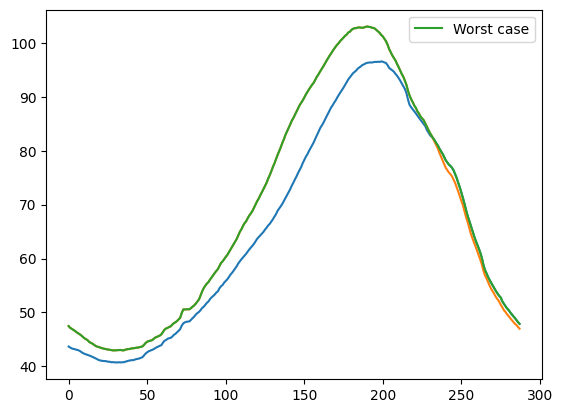

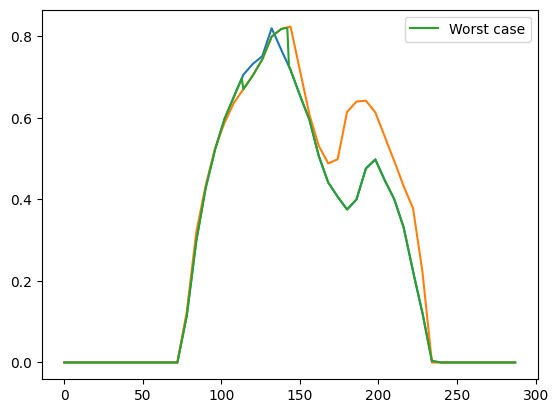

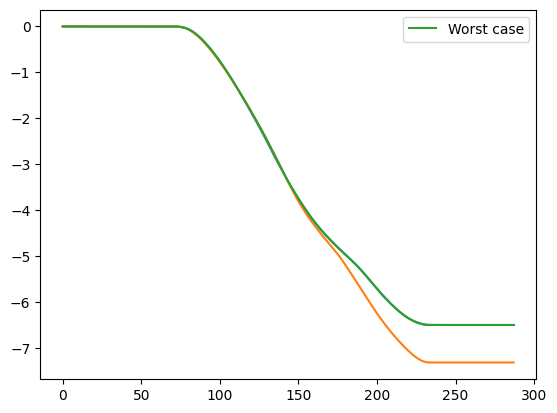

In [24]:
name = 'high_load_cloudy'
days = problem_groups[name]
plt.figure()
plt.plot(load_per_day[days].T)
plt.plot(worst_load[name], label='Worst case')
plt.legend()

plt.figure()
plt.plot(solar_pu_per_day[days].T)
plt.plot(worst_solar_pu[name], label="Worst case")
plt.legend()

plt.figure()
plt.plot(energy_solar_per_day[days].T)
plt.plot(worst_solar_energy[name], label="Worst case")
plt.legend()

In [26]:
cap_ratio = peak_loads / daily_solar

In [27]:
help(topo_argmax)

Help on function topo_argmax in module renewableopt.peak_id:

topo_argmax(arr)



In [28]:
topo_argmax(cap_ratio)

array([151])

In [41]:
np.argmin(cap_ratio)

76

In [39]:
problem_days[np.argmin(cap_ratio[problem_days])]

76

In [ ]:
p

In [34]:
cap_ratio.shape

(366,)

In [40]:
problem_days

array([ 76, 193, 208, 209, 224, 225, 252, 334, 347, 352])

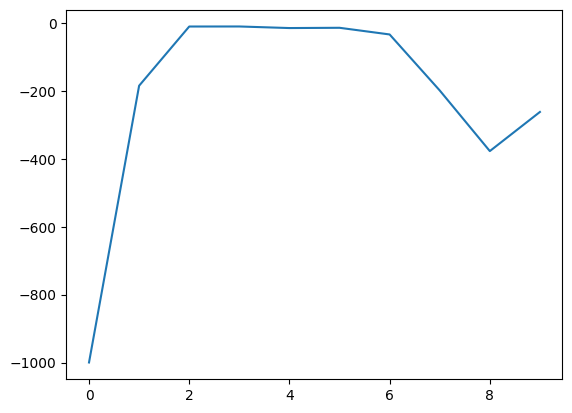

In [38]:
plt.plot(cap_ratio[np.sort(problem_days)])

In [ ]:
cap_ratio()

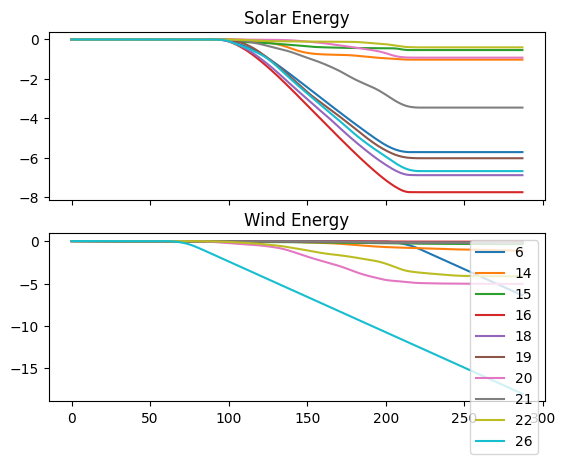

In [12]:
# Double check that integration is working
# for i in np.argwhere(solar_num_less_than == 0):
_, plots = plt.subplots(2, 1, sharex=True)
for i in topo_argmax(energy_gen_per_day)[:10]:
    plots[0].plot(energy_gen_per_day[i, :, 0], label=i)
    plots[1].plot(energy_gen_per_day[i, :, 1], label=i)
#     plots[2].plot(energy_gen_per_day[i, :, 2], label=i)
plots[0].set_title("Solar Energy")
plots[1].set_title("Wind Energy")
plt.legend()
